# PERM EB2 Approval Rate Prediction - Optimized Version

## Key Optimizations:
1. **Combines ALL uploaded years** (2022, 2023, 2024)
2. **Certified-Expired = Approved** (USCIS approved, employer didn't file I-140 in time)
3. **Optimized for F1 Score** (best for approval probability prediction)
4. **Better feature engineering** with interaction terms
5. **Threshold optimization** for practical use

## Use Case: Law Firm Case Prioritization
- High probability cases → Streamline workflow
- Low probability cases → Prioritize extra attention

## Why F1 Score (per professor's feedback)?
- F1 is the harmonic mean of precision and recall
- Better for predicting approval probability (classification task)
- Balances false positives and false negatives
- More appropriate when predicting binary outcomes


In [3]:
!pip install -q mlflow==2.16.0 openpyxl scikit-learn==1.5.1 joblib databricks-sdk==0.36.0 xgboost lightgbm

import pandas as pd
import numpy as np
import os
import joblib
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Modeling + preprocessing libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

print("✔ All libraries imported successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires s

In [4]:
# =================================================================================
# CONFIGURATION: Connect to Databricks MLflow
# ===================================================================================
from google.colab import userdata

databricks_host = userdata.get('DATABRICKS_HOST')
databricks_token = userdata.get('DATABRICKS_TOKEN')

os.environ['DATABRICKS_HOST'] = databricks_host
os.environ['DATABRICKS_TOKEN'] = databricks_token

mlflow.set_tracking_uri("databricks")

# New experiment name for optimized runs
experiment_name = "/Users/shukhany@asu.edu/Perm_EB2_MultiYear_2022_2024"
mlflow.set_experiment(experiment_name)

print(f"✔ Connected to Databricks MLflow")
print(f"✔ Experiment: {experiment_name}")

✔ Connected to Databricks MLflow
✔ Experiment: /Users/shukhany@asu.edu/Perm_EB2_MultiYear_2022_2024


In [5]:
# =================================================================================
# LOAD AND COMBINE ALL PERM DATA FILES
# =================================================================================
from google.colab import files

print("📂 Please upload ALL your PERM Excel files (2022, 2023, 2024)")
print("   You can select multiple files at once!")
uploaded = files.upload()

# Load and combine ALL uploaded files
all_dataframes = []

for filename in uploaded.keys():
    print(f"\n📄 Loading: {filename}")
    df = pd.read_excel(filename, engine="openpyxl")

    # Extract year from filename for tracking
    if "2022" in filename:
        df["DATA_YEAR"] = 2022
    elif "2023" in filename:
        df["DATA_YEAR"] = 2023
    elif "2024" in filename:
        df["DATA_YEAR"] = 2024
    else:
        df["DATA_YEAR"] = 0  # Unknown

    print(f"   Shape: {df.shape}")
    print(f"   Case Status Distribution:")
    print(df['CASE_STATUS'].value_counts().to_string().replace('\n', '\n   '))

    all_dataframes.append(df)

# Combine all years
perm_raw = pd.concat(all_dataframes, ignore_index=True)

print("\n" + "="*60)
print("COMBINED DATASET")
print("="*60)
print(f"Total Shape: {perm_raw.shape}")
print(f"\nCombined Case Status Distribution:")
print(perm_raw['CASE_STATUS'].value_counts())
print(f"\nRecords by Year:")
print(perm_raw['DATA_YEAR'].value_counts().sort_index())

📂 Please upload ALL your PERM Excel files (2022, 2023, 2024)
   You can select multiple files at once!


Saving PERM_2024.xlsx to PERM_2024.xlsx
Saving PERM_2023.xlsx to PERM_2023.xlsx
Saving PERM_2022.xlsx to PERM_2022.xlsx

📄 Loading: PERM_2024.xlsx
   Shape: (92258, 156)
   Case Status Distribution:
CASE_STATUS
   Certified-Expired    50814
   Certified            35505
   Denied                4892
   Withdrawn             1047

📄 Loading: PERM_2023.xlsx
   Shape: (116427, 155)
   Case Status Distribution:
CASE_STATUS
   Certified            52715
   Certified-Expired    49571
   Withdrawn             7777
   Denied                6364

📄 Loading: PERM_2022.xlsx
   Shape: (104600, 155)
   Case Status Distribution:
CASE_STATUS
   Certified-Expired    54023
   Certified            40462
   Withdrawn             5542
   Denied                4573

COMBINED DATASET
Total Shape: (313285, 158)

Combined Case Status Distribution:
CASE_STATUS
Certified-Expired    154408
Certified            128682
Denied                15829
Withdrawn             14366
Name: count, dtype: int64

Records by Ye

In [6]:
# =================================================================================
# IMPROVED TARGET DEFINITION
# Certified-Expired = USCIS APPROVED (employer just didn't file I-140 in time)
# =================================================================================

perm = perm_raw[perm_raw["CASE_STATUS"].notna()].copy()

# Define APPROVED as: Certified OR Certified-Expired
# Both mean USCIS approved the labor certification!
approved_statuses = ["Certified", "Certified-Expired"]

perm["TARGET_APPROVED"] = np.where(
    perm["CASE_STATUS"].isin(approved_statuses),
    1,
    0
)

print("="*60)
print("TARGET DEFINITION (IMPROVED)")
print("="*60)
print("\nApproved (TARGET=1): Certified + Certified-Expired")
print("Denied (TARGET=0): Denied + Withdrawn")
print("\nRationale: Certified-Expired means USCIS APPROVED the PERM.")
print("The employer simply didn't file the I-140 petition in time.")
print("For predicting USCIS approval, this IS an approval.")

print("\n" + "-"*40)
print("Class Distribution:")
print("-"*40)
print(f"Approved (1): {perm['TARGET_APPROVED'].sum():,} ({perm['TARGET_APPROVED'].mean():.1%})")
print(f"Denied (0):   {(perm['TARGET_APPROVED']==0).sum():,} ({(perm['TARGET_APPROVED']==0).mean():.1%})")

print("\n" + "-"*40)
print("Original Status → Target Mapping:")
print("-"*40)
mapping_check = perm.groupby('CASE_STATUS')['TARGET_APPROVED'].agg(['count', 'mean'])
mapping_check.columns = ['Count', 'Target Value']
print(mapping_check)

TARGET DEFINITION (IMPROVED)

Approved (TARGET=1): Certified + Certified-Expired
Denied (TARGET=0): Denied + Withdrawn

Rationale: Certified-Expired means USCIS APPROVED the PERM.
The employer simply didn't file the I-140 petition in time.
For predicting USCIS approval, this IS an approval.

----------------------------------------
Class Distribution:
----------------------------------------
Approved (1): 283,090 (90.4%)
Denied (0):   30,195 (9.6%)

----------------------------------------
Original Status → Target Mapping:
----------------------------------------
                    Count  Target Value
CASE_STATUS                            
Certified          128682           1.0
Certified-Expired  154408           1.0
Denied              15829           0.0
Withdrawn           14366           0.0


In [7]:
# =================================================================================
# ENHANCED FEATURE ENGINEERING
# =================================================================================

# 1) Wage normalization function
def to_annual(wage_series, unit_series):
    unit_series = unit_series.astype(str).str.strip()
    factor_map = {
        "Hour": 2080,
        "Week": 52,
        "Bi-Weekly": 26,
        "Month": 12,
        "Year": 1,
    }
    factors = unit_series.map(factor_map).fillna(1)
    return wage_series * factors

# 2) Create wage features
perm["PW_WAGE_ANNUAL"] = to_annual(perm["PW_WAGE"], perm["PW_UNIT_OF_PAY"])

# Offered wage (midpoint)
offer_mid = perm[["WAGE_OFFER_FROM", "WAGE_OFFER_TO"]].mean(axis=1)
perm["OFFER_WAGE_ANNUAL"] = to_annual(offer_mid, perm["WAGE_OFFER_UNIT_OF_PAY"])

# Wage ratio and premium
perm["WAGE_RATIO"] = perm["OFFER_WAGE_ANNUAL"] / perm["PW_WAGE_ANNUAL"]
perm["WAGE_PREMIUM"] = perm["OFFER_WAGE_ANNUAL"] - perm["PW_WAGE_ANNUAL"]

# Log-transformed wages (handles skewness)
perm["LOG_PW_WAGE"] = np.log1p(perm["PW_WAGE_ANNUAL"])
perm["LOG_OFFER_WAGE"] = np.log1p(perm["OFFER_WAGE_ANNUAL"])

# 3) Group SOC codes into major groups (first 2 digits)
perm["SOC_MAJOR"] = perm["PW_SOC_CODE"].astype(str).str[:2]

# 4) Group NAICS codes into sectors (first 2 digits)
perm["NAICS_SECTOR"] = perm["NAICS_CODE"].astype(str).str[:2]

# 5) Education encoding (ordinal)
education_order = {
    "None": 0,
    "High School": 1,
    "Associate's": 2,
    "Bachelor's": 3,
    "Master's": 4,
    "Doctorate": 5,
    "Other": 2
}
perm["EDUCATION_LEVEL"] = perm["MINIMUM_EDUCATION"].map(education_order).fillna(2)

# 6) Ownership interest binary
perm["HAS_OWNERSHIP"] = np.where(perm["FW_OWNERSHIP_INTEREST"] == "Y", 1, 0)

# 7) State grouping by region (reduces cardinality)
state_regions = {
    # Northeast
    'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast', 'NH': 'Northeast',
    'RI': 'Northeast', 'VT': 'Northeast', 'NJ': 'Northeast', 'NY': 'Northeast', 'PA': 'Northeast',
    # Midwest
    'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest', 'WI': 'Midwest',
    'IA': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest',
    'ND': 'Midwest', 'SD': 'Midwest',
    # South
    'DE': 'South', 'FL': 'South', 'GA': 'South', 'MD': 'South', 'NC': 'South',
    'SC': 'South', 'VA': 'South', 'DC': 'South', 'WV': 'South', 'AL': 'South',
    'KY': 'South', 'MS': 'South', 'TN': 'South', 'AR': 'South', 'LA': 'South',
    'OK': 'South', 'TX': 'South',
    # West
    'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West', 'NV': 'West',
    'NM': 'West', 'UT': 'West', 'WY': 'West', 'AK': 'West', 'CA': 'West',
    'HI': 'West', 'OR': 'West', 'WA': 'West'
}
perm["REGION"] = perm["WORKSITE_STATE"].map(state_regions).fillna("Other")

# 8) Clean data
perm = perm.replace([np.inf, -np.inf], np.nan)

# Features for modeling
cols_for_model = [
    "TARGET_APPROVED",
    # Numeric features
    "PW_WAGE_ANNUAL",
    "OFFER_WAGE_ANNUAL",
    "WAGE_RATIO",
    "WAGE_PREMIUM",
    "LOG_PW_WAGE",
    "LOG_OFFER_WAGE",
    "EDUCATION_LEVEL",
    "HAS_OWNERSHIP",
    "DATA_YEAR",
    # Categorical features
    "SOC_MAJOR",
    "NAICS_SECTOR",
    "REGION",
    "WORKSITE_STATE"
]

perm_model = perm[cols_for_model].dropna()

print("="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)
print(f"\nFinal modeling shape: {perm_model.shape}")
print(f"Approval rate: {perm_model['TARGET_APPROVED'].mean():.1%}")
print(f"\nFeatures created:")
for col in cols_for_model[1:]:
    print(f"  - {col}")

FEATURE ENGINEERING COMPLETE

Final modeling shape: (313213, 14)
Approval rate: 90.4%

Features created:
  - PW_WAGE_ANNUAL
  - OFFER_WAGE_ANNUAL
  - WAGE_RATIO
  - WAGE_PREMIUM
  - LOG_PW_WAGE
  - LOG_OFFER_WAGE
  - EDUCATION_LEVEL
  - HAS_OWNERSHIP
  - DATA_YEAR
  - SOC_MAJOR
  - NAICS_SECTOR
  - REGION
  - WORKSITE_STATE


In [8]:
# =================================================================================
# PREPARE DATA FOR MODELING
# =================================================================================

y = perm_model["TARGET_APPROVED"].astype(int)
X = perm_model.drop(columns=["TARGET_APPROVED"])

# Define feature types
numeric_features = [
    "PW_WAGE_ANNUAL", "OFFER_WAGE_ANNUAL", "WAGE_RATIO", "WAGE_PREMIUM",
    "LOG_PW_WAGE", "LOG_OFFER_WAGE", "EDUCATION_LEVEL", "HAS_OWNERSHIP", "DATA_YEAR"
]
categorical_features = ["SOC_MAJOR", "NAICS_SECTOR", "REGION", "WORKSITE_STATE"]

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Ensure categoricals are strings
for c in categorical_features:
    X[c] = X[c].astype(str)

# Preprocessor
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False,
    max_categories=50  # Limit categories to prevent explosion
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain: {X_train.shape[0]:,} samples")
print(f"Test:  {X_test.shape[0]:,} samples")
print(f"\nApproval rate - Train: {y_train.mean():.1%}, Test: {y_test.mean():.1%}")

Numeric features (9): ['PW_WAGE_ANNUAL', 'OFFER_WAGE_ANNUAL', 'WAGE_RATIO', 'WAGE_PREMIUM', 'LOG_PW_WAGE', 'LOG_OFFER_WAGE', 'EDUCATION_LEVEL', 'HAS_OWNERSHIP', 'DATA_YEAR']
Categorical features (4): ['SOC_MAJOR', 'NAICS_SECTOR', 'REGION', 'WORKSITE_STATE']

Train: 250,570 samples
Test:  62,643 samples

Approval rate - Train: 90.4%, Test: 90.4%


In [9]:
# =================================================================================
# MODEL CONFIGURATIONS - ALL PROFESSOR'S REQUIRED MODELS
# =================================================================================
#
# ✅ Classification tree (Decision Tree)
# ✅ Logistic regression
# ✅ Support vector machine (SVM) - IN SEPARATE CELL (requires sampling for large data)
# ✅ Neural network
# ✅ Naive Bayes
# ✅ Random forest
# ✅ XGBoost
# ✅ K nearest neighbors (KNN)
# ✅ Ensemble models (AdaBoost, Gradient Boosting, LightGBM)
#
# Each model has 2-3 hyperparameters with at least 2 values each
# =================================================================================

from sklearn.neighbors import KNeighborsClassifier

model_configs = [
    # =========== 1. DECISION TREE (Classification Tree) ===========
    # Hyperparameters: max_depth, min_samples_leaf
    {"name": "DT_depth5", "model": DecisionTreeClassifier(
        max_depth=5, min_samples_leaf=100, class_weight="balanced", random_state=42)},
    {"name": "DT_depth10", "model": DecisionTreeClassifier(
        max_depth=10, min_samples_leaf=50, class_weight="balanced", random_state=42)},
    {"name": "DT_depth15", "model": DecisionTreeClassifier(
        max_depth=15, min_samples_leaf=30, class_weight="balanced", random_state=42)},
    {"name": "DT_depthNone", "model": DecisionTreeClassifier(
        max_depth=None, min_samples_leaf=20, class_weight="balanced", random_state=42)},

    # =========== 2. LOGISTIC REGRESSION ===========
    # Hyperparameters: C (regularization)
    {"name": "LOGIT_C0.01", "model": LogisticRegression(
        C=0.01, max_iter=1000, class_weight="balanced", solver='lbfgs', n_jobs=-1)},
    {"name": "LOGIT_C0.1", "model": LogisticRegression(
        C=0.1, max_iter=1000, class_weight="balanced", solver='lbfgs', n_jobs=-1)},
    {"name": "LOGIT_C1.0", "model": LogisticRegression(
        C=1.0, max_iter=1000, class_weight="balanced", solver='lbfgs', n_jobs=-1)},
    {"name": "LOGIT_C10.0", "model": LogisticRegression(
        C=10.0, max_iter=1000, class_weight="balanced", solver='lbfgs', n_jobs=-1)},

    # =========== 3. NEURAL NETWORK ===========
    # Hyperparameters: hidden_layer_sizes, alpha
    {"name": "NN_h(64)_alpha0.0001", "model": MLPClassifier(
        hidden_layer_sizes=(64,), alpha=0.0001, max_iter=300, early_stopping=True, random_state=42)},
    {"name": "NN_h(128,64)_alpha0.0001", "model": MLPClassifier(
        hidden_layer_sizes=(128, 64), alpha=0.0001, max_iter=300, early_stopping=True, random_state=42)},
    {"name": "NN_h(128,64)_alpha0.001", "model": MLPClassifier(
        hidden_layer_sizes=(128, 64), alpha=0.001, max_iter=300, early_stopping=True, random_state=42)},
    {"name": "NN_h(256,128,64)_alpha0.0001", "model": MLPClassifier(
        hidden_layer_sizes=(256, 128, 64), alpha=0.0001, max_iter=300, early_stopping=True, random_state=42)},

    # =========== 4. NAIVE BAYES ===========
    # Hyperparameter: var_smoothing
    {"name": "NB_var1e-9", "model": GaussianNB(var_smoothing=1e-9)},
    {"name": "NB_var1e-5", "model": GaussianNB(var_smoothing=1e-5)},
    {"name": "NB_var0.001", "model": GaussianNB(var_smoothing=0.001)},
    {"name": "NB_var0.01", "model": GaussianNB(var_smoothing=0.01)},

    # =========== 5. RANDOM FOREST ===========
    # Hyperparameters: n_estimators, max_depth
    {"name": "RF_n100_depth10", "model": RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_leaf=50, class_weight="balanced", random_state=42, n_jobs=-1)},
    {"name": "RF_n200_depth15", "model": RandomForestClassifier(
        n_estimators=200, max_depth=15, min_samples_leaf=30, class_weight="balanced", random_state=42, n_jobs=-1)},
    {"name": "RF_n300_depth20", "model": RandomForestClassifier(
        n_estimators=300, max_depth=20, min_samples_leaf=20, class_weight="balanced", random_state=42, n_jobs=-1)},
    {"name": "RF_n300_depthNone", "model": RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=10, class_weight="balanced", random_state=42, n_jobs=-1)},

    # =========== 6. XGBOOST ===========
    # Hyperparameters: n_estimators, learning_rate, max_depth
    {"name": "XGB_n100_lr0.1_depth5", "model": xgb.XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1, verbosity=0)},
    {"name": "XGB_n200_lr0.05_depth7", "model": xgb.XGBClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42, n_jobs=-1, verbosity=0)},
    {"name": "XGB_n300_lr0.1_depth7", "model": xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.1, max_depth=7, random_state=42, n_jobs=-1, verbosity=0)},
    {"name": "XGB_n300_lr0.05_depth10", "model": xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=10, random_state=42, n_jobs=-1, verbosity=0)},

    # =========== 7. K-NEAREST NEIGHBORS (KNN) ===========
    # Hyperparameters: n_neighbors, weights, metric
    {"name": "KNN_k3_uniform", "model": KNeighborsClassifier(
        n_neighbors=3, weights='uniform', metric='euclidean', n_jobs=-1)},
    {"name": "KNN_k5_uniform", "model": KNeighborsClassifier(
        n_neighbors=5, weights='uniform', metric='euclidean', n_jobs=-1)},
    {"name": "KNN_k7_uniform", "model": KNeighborsClassifier(
        n_neighbors=7, weights='uniform', metric='euclidean', n_jobs=-1)},
    {"name": "KNN_k5_distance", "model": KNeighborsClassifier(
        n_neighbors=5, weights='distance', metric='euclidean', n_jobs=-1)},
    {"name": "KNN_k7_distance", "model": KNeighborsClassifier(
        n_neighbors=7, weights='distance', metric='euclidean', n_jobs=-1)},
    {"name": "KNN_k10_distance", "model": KNeighborsClassifier(
        n_neighbors=10, weights='distance', metric='euclidean', n_jobs=-1)},
    {"name": "KNN_k5_manhattan", "model": KNeighborsClassifier(
        n_neighbors=5, weights='uniform', metric='manhattan', n_jobs=-1)},
    {"name": "KNN_k7_manhattan", "model": KNeighborsClassifier(
        n_neighbors=7, weights='distance', metric='manhattan', n_jobs=-1)},

    # =========== 8. ENSEMBLE MODELS ===========

    # Gradient Boosting
    # Hyperparameters: n_estimators, learning_rate, max_depth
    {"name": "GB_n100_lr0.05_depth3", "model": GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)},
    {"name": "GB_n100_lr0.1_depth5", "model": GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)},
    {"name": "GB_n200_lr0.1_depth5", "model": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)},
    {"name": "GB_n300_lr0.05_depth7", "model": GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42)},

    # LightGBM
    # Hyperparameters: n_estimators, learning_rate, num_leaves
    {"name": "LGBM_n100_lr0.1_leaves31", "model": lgb.LGBMClassifier(
        n_estimators=100, learning_rate=0.1, num_leaves=31, class_weight="balanced", random_state=42, n_jobs=-1, verbosity=-1)},
    {"name": "LGBM_n200_lr0.05_leaves63", "model": lgb.LGBMClassifier(
        n_estimators=200, learning_rate=0.05, num_leaves=63, class_weight="balanced", random_state=42, n_jobs=-1, verbosity=-1)},
    {"name": "LGBM_n300_lr0.1_leaves127", "model": lgb.LGBMClassifier(
        n_estimators=300, learning_rate=0.1, num_leaves=127, class_weight="balanced", random_state=42, n_jobs=-1, verbosity=-1)},

    # AdaBoost
    # Hyperparameters: n_estimators, learning_rate
    {"name": "ADA_n100_lr0.5", "model": AdaBoostClassifier(
        n_estimators=100, learning_rate=0.5, random_state=42)},
    {"name": "ADA_n200_lr1.0", "model": AdaBoostClassifier(
        n_estimators=200, learning_rate=1.0, random_state=42)},
    {"name": "ADA_n200_lr0.5", "model": AdaBoostClassifier(
        n_estimators=200, learning_rate=0.5, random_state=42)},
]

print("="*70)
print("MODEL CONFIGURATIONS (SVM in separate cell)")
print("="*70)
print(f"\nModels in main loop: {len(model_configs)}")
print("SVM models: 6 (in separate cell with sampled data)")
print(f"Total models: {len(model_configs) + 6}")
print("\nModel families:")

families = {}
for config in model_configs:
    family = config['name'].split('_')[0]
    families[family] = families.get(family, 0) + 1

for family, count in sorted(families.items()):
    print(f"  ✅ {family}: {count} configurations")
print(f"  ✅ SVM: 6 configurations (separate cell)")

print("\n" + "="*70)
print("PROFESSOR'S REQUIREMENTS CHECKLIST:")
print("="*70)
print("  ✅ Classification tree (DT)")
print("  ✅ Logistic regression (LOGIT)")
print("  ✅ Support vector machine (SVM) - separate cell")
print("  ✅ Neural network (NN)")
print("  ✅ Naive Bayes (NB)")
print("  ✅ Random forest (RF)")
print("  ✅ XGBoost (XGB)")
print("  ✅ K nearest neighbors (KNN)")
print("  ✅ Ensemble models (GB, LGBM, ADA)")

MODEL CONFIGURATIONS (SVM in separate cell)

Models in main loop: 42
SVM models: 6 (in separate cell with sampled data)
Total models: 48

Model families:
  ✅ ADA: 3 configurations
  ✅ DT: 4 configurations
  ✅ GB: 4 configurations
  ✅ KNN: 8 configurations
  ✅ LGBM: 3 configurations
  ✅ LOGIT: 4 configurations
  ✅ NB: 4 configurations
  ✅ NN: 4 configurations
  ✅ RF: 4 configurations
  ✅ XGB: 4 configurations
  ✅ SVM: 6 configurations (separate cell)

PROFESSOR'S REQUIREMENTS CHECKLIST:
  ✅ Classification tree (DT)
  ✅ Logistic regression (LOGIT)
  ✅ Support vector machine (SVM) - separate cell
  ✅ Neural network (NN)
  ✅ Naive Bayes (NB)
  ✅ Random forest (RF)
  ✅ XGBoost (XGB)
  ✅ K nearest neighbors (KNN)
  ✅ Ensemble models (GB, LGBM, ADA)


In [10]:
# =================================================================================
# TRAINING LOOP - Optimized for F1 Score
# =================================================================================

results = []

print("="*70)
print("TRAINING MODELS - Primary Metric: F1 Score")
print("="*70)

for i, config in enumerate(model_configs):
    name = config["name"]
    base_model = config["model"]

    print(f"\n[{i+1}/{len(model_configs)}] Training: {name}")

    # Create pipeline
    clf = Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", base_model),
    ])

    try:
        with mlflow.start_run(run_name=name):
            # Log model info
            mlflow.log_param("model", name)
            mlflow.log_param("train_samples", len(X_train))
            mlflow.log_param("test_samples", len(X_test))

            # Fit model
            clf.fit(X_train, y_train)

            # Get probability scores
            if hasattr(clf["clf"], "predict_proba"):
                y_proba = clf.predict_proba(X_test)[:, 1]
            elif hasattr(clf["clf"], "decision_function"):
                scores = clf.decision_function(X_test)
                y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
            else:
                y_proba = clf.predict(X_test).astype(float)

            # Predictions
            y_pred = (y_proba >= 0.5).astype(int)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            test_accuracy = accuracy_score(y_test, y_pred)
            test_f1 = f1_score(y_test, y_pred, zero_division=0)
            test_precision = precision_score(y_test, y_pred, zero_division=0)
            test_recall = recall_score(y_test, y_pred, zero_division=0)

            # Log metrics
            mlflow.log_metric("f1_score", test_f1)
            mlflow.log_metric("roc_auc", roc_auc)
            mlflow.log_metric("test_accuracy", test_accuracy)
            mlflow.log_metric("test_precision", test_precision)
            mlflow.log_metric("test_recall", test_recall)

            # Log model
            mlflow.sklearn.log_model(clf, "model")

            # Print results (F1 highlighted as primary metric)
            print(f"   ★ F1: {test_f1:.4f} | Acc: {test_accuracy:.4f} | ROC-AUC: {roc_auc:.4f}")

            # Save results
            results.append({
                "model": name,
                "f1": test_f1,
                "roc_auc": roc_auc,
                "accuracy": test_accuracy,
                "precision": test_precision,
                "recall": test_recall,
            })

            # Save model
            joblib.dump(clf, f"model_{name}.pkl")

    except Exception as e:
        print(f"   ❌ Error: {str(e)[:50]}")
        continue


TRAINING MODELS - Primary Metric: ROC-AUC

[1/42] Training: DT_depth5


2025/12/05 02:25:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7310 | Acc: 0.7267 | F1: 0.8299


2025/12/05 02:25:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run DT_depth5 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/6eacc44843ea4d9bb8fd7d860282fcfc.
2025/12/05 02:25:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[2/42] Training: DT_depth10


2025/12/05 02:25:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7650 | Acc: 0.7549 | F1: 0.8499


2025/12/05 02:25:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run DT_depth10 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/1a8787421da84fb6a63ada317f3638a0.
2025/12/05 02:25:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[3/42] Training: DT_depth15


2025/12/05 02:25:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7755 | Acc: 0.7681 | F1: 0.8591


2025/12/05 02:25:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run DT_depth15 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/6c705707256f40368dd0d17ee8fab7c1.
2025/12/05 02:25:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[4/42] Training: DT_depthNone


2025/12/05 02:26:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7778 | Acc: 0.7489 | F1: 0.8450


2025/12/05 02:26:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run DT_depthNone at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/49953abc89984965a559c4b8d6ee145a.
2025/12/05 02:26:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[5/42] Training: LOGIT_C0.01


2025/12/05 02:26:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7193 | Acc: 0.7001 | F1: 0.8101


2025/12/05 02:26:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run LOGIT_C0.01 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/44cf036bf37042a68f6dd6bf30e996e1.
2025/12/05 02:26:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[6/42] Training: LOGIT_C0.1


2025/12/05 02:26:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7199 | Acc: 0.7010 | F1: 0.8109


2025/12/05 02:26:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run LOGIT_C0.1 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/c262d5a29b8a4a23bce39f612c6af119.
2025/12/05 02:26:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[7/42] Training: LOGIT_C1.0


2025/12/05 02:26:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7200 | Acc: 0.7025 | F1: 0.8120


2025/12/05 02:26:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run LOGIT_C1.0 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/e16d2bc78aea4367bac007e149cf144a.
2025/12/05 02:26:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[8/42] Training: LOGIT_C10.0


2025/12/05 02:27:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7200 | Acc: 0.7013 | F1: 0.8111


2025/12/05 02:27:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run LOGIT_C10.0 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/ad7a156f0ba046bba1a3f54ce9eddf81.
2025/12/05 02:27:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[9/42] Training: NN_h(64)_alpha0.0001


2025/12/05 02:28:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7689 | Acc: 0.9173 | F1: 0.9561


2025/12/05 02:28:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run NN_h(64)_alpha0.0001 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/110c48bbaafa436db665b714531411d0.
2025/12/05 02:28:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[10/42] Training: NN_h(128,64)_alpha0.0001


2025/12/05 02:29:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7811 | Acc: 0.9190 | F1: 0.9567


2025/12/05 02:29:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run NN_h(128,64)_alpha0.0001 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/e84df8f0e05d414c8fe59b02fd8894b8.
2025/12/05 02:29:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[11/42] Training: NN_h(128,64)_alpha0.001


2025/12/05 02:32:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7819 | Acc: 0.9197 | F1: 0.9570


2025/12/05 02:32:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run NN_h(128,64)_alpha0.001 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/55693da82c4f4bce85aa45d7816a877c.
2025/12/05 02:32:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[12/42] Training: NN_h(256,128,64)_alpha0.0001


2025/12/05 02:36:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7821 | Acc: 0.9210 | F1: 0.9578


2025/12/05 02:36:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run NN_h(256,128,64)_alpha0.0001 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/69b6ceea28ca4bc79aa5b83e4fc0f2f7.
2025/12/05 02:36:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[13/42] Training: NB_var1e-9


2025/12/05 02:36:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.6818 | Acc: 0.7628 | F1: 0.8579


2025/12/05 02:36:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run NB_var1e-9 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/8bda36fc4dbf4904a00b3117d7277b19.
2025/12/05 02:36:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[14/42] Training: NB_var1e-5


2025/12/05 02:37:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.6816 | Acc: 0.7855 | F1: 0.8741


2025/12/05 02:37:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run NB_var1e-5 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/3b0715176a6b4e42822b292bcb09fa62.
2025/12/05 02:37:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[15/42] Training: NB_var0.001


2025/12/05 02:37:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.6841 | Acc: 0.7671 | F1: 0.8609


2025/12/05 02:37:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run NB_var0.001 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/16ea19cfb6fa4083b780a49bd507a8e5.
2025/12/05 02:37:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[16/42] Training: NB_var0.01


2025/12/05 02:37:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.6910 | Acc: 0.7834 | F1: 0.8721


2025/12/05 02:37:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run NB_var0.01 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/81e2581c82164b0ebd305f7cba669d6c.
2025/12/05 02:37:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[17/42] Training: RF_n100_depth10


2025/12/05 02:38:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7580 | Acc: 0.7554 | F1: 0.8507


2025/12/05 02:38:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run RF_n100_depth10 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/72aa24ce25f34067a13190bcacf3f462.
2025/12/05 02:38:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[18/42] Training: RF_n200_depth15


2025/12/05 02:39:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7807 | Acc: 0.7762 | F1: 0.8649


2025/12/05 02:39:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run RF_n200_depth15 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/6633965653044a518767f2ca06880e08.
2025/12/05 02:39:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[19/42] Training: RF_n300_depth20


2025/12/05 02:41:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7962 | Acc: 0.7990 | F1: 0.8804


2025/12/05 02:42:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run RF_n300_depth20 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/d6036692631e424c8388ffc0d946bfbd.
2025/12/05 02:42:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[20/42] Training: RF_n300_depthNone


2025/12/05 02:44:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.8175 | Acc: 0.8474 | F1: 0.9119


2025/12/05 02:45:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run RF_n300_depthNone at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/e437c8b05d6d44d782f5d3463f62bd07.
2025/12/05 02:45:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[21/42] Training: XGB_n100_lr0.1_depth5


2025/12/05 02:45:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7699 | Acc: 0.9149 | F1: 0.9550


2025/12/05 02:45:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_n100_lr0.1_depth5 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/48e302be144c481c8b508b2659b70d6e.
2025/12/05 02:45:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[22/42] Training: XGB_n200_lr0.05_depth7


2025/12/05 02:45:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7850 | Acc: 0.9200 | F1: 0.9575


2025/12/05 02:45:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_n200_lr0.05_depth7 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/e20af74da3064b218f9e0c01c020c639.
2025/12/05 02:45:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[23/42] Training: XGB_n300_lr0.1_depth7


2025/12/05 02:46:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.8057 | Acc: 0.9259 | F1: 0.9605


2025/12/05 02:46:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_n300_lr0.1_depth7 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/ebf431a641734cb187ebe20652b5f4a8.
2025/12/05 02:46:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[24/42] Training: XGB_n300_lr0.05_depth10


2025/12/05 02:47:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.8116 | Acc: 0.9267 | F1: 0.9609


2025/12/05 02:47:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGB_n300_lr0.05_depth10 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/9342942cb82d4d0bbb7e874105aee552.
2025/12/05 02:47:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[25/42] Training: KNN_k3_uniform


2025/12/05 02:50:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7382 | Acc: 0.9192 | F1: 0.9562


2025/12/05 02:50:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_k3_uniform at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/8d43289448524f30babd9df83d3b5ea4.
2025/12/05 02:50:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[26/42] Training: KNN_k5_uniform


2025/12/05 02:54:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7572 | Acc: 0.9238 | F1: 0.9590


2025/12/05 02:54:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_k5_uniform at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/761656e2716347d3b42292d1d33135ee.
2025/12/05 02:54:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[27/42] Training: KNN_k7_uniform


2025/12/05 02:58:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7712 | Acc: 0.9248 | F1: 0.9596


2025/12/05 02:58:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_k7_uniform at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/acb976572745461abb23b038ae636b9b.
2025/12/05 02:58:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[28/42] Training: KNN_k5_distance


2025/12/05 03:02:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7599 | Acc: 0.9200 | F1: 0.9566


2025/12/05 03:02:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_k5_distance at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/da2a3e0ab1084bb3882fe6a3e5125904.
2025/12/05 03:02:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[29/42] Training: KNN_k7_distance


2025/12/05 03:06:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7744 | Acc: 0.9230 | F1: 0.9583


2025/12/05 03:06:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_k7_distance at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/50248af4bae347608768adbd0d2b67cd.
2025/12/05 03:06:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[30/42] Training: KNN_k10_distance


2025/12/05 03:10:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7863 | Acc: 0.9251 | F1: 0.9595


2025/12/05 03:10:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_k10_distance at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/02eda30a33374c238a3ee7795832ed40.
2025/12/05 03:10:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[31/42] Training: KNN_k5_manhattan


2025/12/05 03:54:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7599 | Acc: 0.9245 | F1: 0.9593


2025/12/05 03:54:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_k5_manhattan at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/4af0b1eb99434a6aab1379a5635343af.
2025/12/05 03:54:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[32/42] Training: KNN_k7_manhattan


2025/12/05 04:37:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7761 | Acc: 0.9234 | F1: 0.9585


2025/12/05 04:37:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_k7_manhattan at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/40394747b4654cbf9998f59fa15c924c.
2025/12/05 04:37:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[33/42] Training: GB_n100_lr0.05_depth3


2025/12/05 04:40:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7395 | Acc: 0.9074 | F1: 0.9512


2025/12/05 04:40:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run GB_n100_lr0.05_depth3 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/c02d66429f9f435e8c8266e70f016c8a.
2025/12/05 04:40:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[34/42] Training: GB_n100_lr0.1_depth5


2025/12/05 04:48:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7689 | Acc: 0.9178 | F1: 0.9564


2025/12/05 04:48:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run GB_n100_lr0.1_depth5 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/866ecaf518b04862bfccb67b732619ad.
2025/12/05 04:48:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[35/42] Training: GB_n200_lr0.1_depth5


2025/12/05 04:59:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7801 | Acc: 0.9217 | F1: 0.9584


2025/12/05 04:59:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run GB_n200_lr0.1_depth5 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/1fd51e96aa124479953ef645d200d9e0.
2025/12/05 04:59:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[36/42] Training: GB_n300_lr0.05_depth7


2025/12/05 05:21:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7908 | Acc: 0.9242 | F1: 0.9597


2025/12/05 05:21:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run GB_n300_lr0.05_depth7 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/49c685c579ea48108a8e7dfffe61cbbd.
2025/12/05 05:21:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[37/42] Training: LGBM_n100_lr0.1_leaves31


2025/12/05 05:21:55 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-08-29; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'cuda-core'}
2025/12/05 05:21:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7857 | Acc: 0.7726 | F1: 0.8621


2025/12/05 05:21:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run LGBM_n100_lr0.1_leaves31 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/be04e7a2007946f8b47f3a565d2278ce.
2025/12/05 05:21:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[38/42] Training: LGBM_n200_lr0.05_leaves63


2025/12/05 05:22:14 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-08-29; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'cuda-core'}
2025/12/05 05:22:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.8012 | Acc: 0.7946 | F1: 0.8770


2025/12/05 05:22:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run LGBM_n200_lr0.05_leaves63 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/12f210f052ac49bc89370079971ec27b.
2025/12/05 05:22:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[39/42] Training: LGBM_n300_lr0.1_leaves127


2025/12/05 05:22:39 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-08-29; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'cuda-core'}
2025/12/05 05:22:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.8187 | Acc: 0.8336 | F1: 0.9028


2025/12/05 05:22:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run LGBM_n300_lr0.1_leaves127 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/c08d82a364b44552bf7502f67b353849.
2025/12/05 05:22:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[40/42] Training: ADA_n100_lr0.5


2025/12/05 05:24:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7308 | Acc: 0.9061 | F1: 0.9506


2025/12/05 05:24:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run ADA_n100_lr0.5 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/a825319679e04bd3bb72c0e0492bb382.
2025/12/05 05:24:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[41/42] Training: ADA_n200_lr1.0


2025/12/05 05:27:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7379 | Acc: 0.9080 | F1: 0.9515


2025/12/05 05:27:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run ADA_n200_lr1.0 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/b69f4076a507419fa4e8118c716541ee.
2025/12/05 05:27:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[42/42] Training: ADA_n200_lr0.5


2025/12/05 05:30:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

   ★ ROC-AUC: 0.7341 | Acc: 0.9071 | F1: 0.9511


2025/12/05 05:30:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run ADA_n200_lr0.5 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/8bc7bff97f454fd5931618594588522b.
2025/12/05 05:30:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



✅ Completed 42 model runs


In [11]:
# =================================================================================
# SVM MODELS - SEPARATE CELL WITH SAMPLED DATA
# =================================================================================
# SVM has O(n²) to O(n³) complexity - impractical for 300K+ samples
# Training on 10% sample (~25K samples) which is still statistically significant
# Testing on FULL test set for accurate metrics
# =================================================================================

print("="*70)
print("TRAINING SVM MODELS (with sampled data)")
print("="*70)

# Sample 10% of training data for SVM
sample_fraction = 0.10
sample_size = int(len(X_train) * sample_fraction)
np.random.seed(42)
sample_idx = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train.iloc[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

print(f"\nTraining data: {sample_size:,} samples ({sample_fraction:.0%} of {len(X_train):,})")
print(f"Test data: {len(X_test):,} samples (full test set)")
print("\nNote: SVM trained on sample, but evaluated on full test set for fair comparison")

svm_configs = [
    # Hyperparameters: C, kernel
    {"name": "SVM_C0.1_rbf", "model": SVC(C=0.1, kernel='rbf', probability=True, class_weight='balanced', random_state=42)},
    {"name": "SVM_C1.0_rbf", "model": SVC(C=1.0, kernel='rbf', probability=True, class_weight='balanced', random_state=42)},
    {"name": "SVM_C10.0_rbf", "model": SVC(C=10.0, kernel='rbf', probability=True, class_weight='balanced', random_state=42)},
    {"name": "SVM_C1.0_linear", "model": SVC(C=1.0, kernel='linear', probability=True, class_weight='balanced', random_state=42)},
    {"name": "SVM_C1.0_poly2", "model": SVC(C=1.0, kernel='poly', degree=2, probability=True, class_weight='balanced', random_state=42)},
    {"name": "SVM_C1.0_poly3", "model": SVC(C=1.0, kernel='poly', degree=3, probability=True, class_weight='balanced', random_state=42)},
]

for i, config in enumerate(svm_configs):
    name = config["name"]
    print(f"\n[{i+1}/{len(svm_configs)}] Training: {name}")

    clf = Pipeline(steps=[("preprocess", preprocess), ("clf", config["model"])])

    try:
        with mlflow.start_run(run_name=name):
            # Train on SAMPLED data
            clf.fit(X_train_sample, y_train_sample)

            # Test on FULL test set
            y_proba = clf.predict_proba(X_test)[:, 1]
            y_pred = (y_proba >= 0.5).astype(int)

            # Metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            test_f1 = f1_score(y_test, y_pred, zero_division=0)
            test_accuracy = accuracy_score(y_test, y_pred)
            test_precision = precision_score(y_test, y_pred, zero_division=0)
            test_recall = recall_score(y_test, y_pred, zero_division=0)

            mlflow.log_metric("f1_score", test_f1)
            mlflow.log_metric("roc_auc", roc_auc)
            mlflow.log_metric("accuracy", test_accuracy)
            mlflow.sklearn.log_model(clf, "model")

            # Print results (F1 highlighted as primary metric)
            print(f"   ★ F1: {test_f1:.4f} | Acc: {test_accuracy:.4f} | ROC-AUC: {roc_auc:.4f}")

            results.append({
                "model": name,
                "f1": test_f1,
                "roc_auc": roc_auc,
                "accuracy": test_accuracy,
                "precision": test_precision,
                "recall": test_recall,
            })

            joblib.dump(clf, f"model_{name}.pkl")

    except Exception as e:
        print(f"   ❌ Error: {str(e)[:50]}")


TRAINING SVM MODELS (with sampled data)

Training data: 25,057 samples (10% of 250,570)
Test data: 62,643 samples (full test set)

Note: SVM trained on sample, but evaluated on full test set for fair comparison

[1/6] Training: SVM_C0.1_rbf
   ★ ROC-AUC: 0.7305 | Acc: 0.9038 | F1: 0.9495


2025/12/05 05:42:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVM_C0.1_rbf at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/ba73653f6e4e4523a38adf273db03b90.
2025/12/05 05:42:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[2/6] Training: SVM_C1.0_rbf
   ★ ROC-AUC: 0.7480 | Acc: 0.9038 | F1: 0.9495


2025/12/05 05:55:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVM_C1.0_rbf at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/421abf1d57a647928d828c855f0db519.
2025/12/05 05:55:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[3/6] Training: SVM_C10.0_rbf
   ★ ROC-AUC: 0.7264 | Acc: 0.9038 | F1: 0.9495


2025/12/05 06:09:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVM_C10.0_rbf at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/0e4c240dabbd4a34aa403e8c2091654b.
2025/12/05 06:09:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[4/6] Training: SVM_C1.0_linear
   ★ ROC-AUC: 0.7022 | Acc: 0.9038 | F1: 0.9495


2025/12/05 06:26:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVM_C1.0_linear at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/dd932c11d51447cd8e41468bf1f0ca0e.
2025/12/05 06:26:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[5/6] Training: SVM_C1.0_poly2
   ★ ROC-AUC: 0.7352 | Acc: 0.9038 | F1: 0.9495


2025/12/05 06:36:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVM_C1.0_poly2 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/2f80fd12fb7040b3a6ffa1246f78c734.
2025/12/05 06:36:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



[6/6] Training: SVM_C1.0_poly3
   ★ ROC-AUC: 0.7391 | Acc: 0.9038 | F1: 0.9495


2025/12/05 06:44:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVM_C1.0_poly3 at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742/runs/d8984f1e4a8448c98e601c480cadb2ae.
2025/12/05 06:44:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dbc-ca0a3ce7-da46.cloud.databricks.com/ml/experiments/2146850892363742.



✅ SVM Models Complete!


In [12]:
# =================================================================================
# RESULTS SUMMARY - Sorted by F1 Score (primary metric)
# =================================================================================

results_df = pd.DataFrame(results)

# Sort by F1 Score (primary metric for approval prediction)
results_df = results_df.sort_values("f1", ascending=False).reset_index(drop=True)

# Format
for col in ['f1', 'roc_auc', 'accuracy', 'precision', 'recall']:
    results_df[col] = results_df[col].round(4)

print("\n" + "="*80)
print("ALL MODELS - SORTED BY F1 SCORE (Best for Approval Prediction)")
print("="*80)
print(results_df.to_string(index=False))

print("\n" + "="*80)
print("🏆 TOP 10 MODELS BY F1 SCORE")
print("="*80)
print(results_df.head(10).to_string(index=False))

# Best model
best = results_df.iloc[0]
print("\n" + "="*80)
print(f"🥇 BEST MODEL: {best['model']}")
print("="*80)
print(f"   F1 Score:  {best['f1']:.4f}  ← Primary metric for approval prediction")
print(f"   ROC-AUC:   {best['roc_auc']:.4f}")
print(f"   Accuracy:  {best['accuracy']:.4f}")
print(f"   Precision: {best['precision']:.4f}")
print(f"   Recall:    {best['recall']:.4f}")



ALL MODELS - SORTED BY ROC-AUC (Best for Case Prioritization)
                       model  roc_auc  accuracy     f1  precision  recall
   LGBM_n300_lr0.1_leaves127   0.8187    0.8336 0.9028     0.9565  0.8548
           RF_n300_depthNone   0.8175    0.8474 0.9119     0.9536  0.8737
     XGB_n300_lr0.05_depth10   0.8116    0.9267 0.9609     0.9273  0.9970
       XGB_n300_lr0.1_depth7   0.8057    0.9259 0.9605     0.9266  0.9970
   LGBM_n200_lr0.05_leaves63   0.8012    0.7946 0.8770     0.9557  0.8102
             RF_n300_depth20   0.7962    0.7990 0.8804     0.9528  0.8182
       GB_n300_lr0.05_depth7   0.7908    0.9242 0.9597     0.9247  0.9974
            KNN_k10_distance   0.7863    0.9251 0.9595     0.9376  0.9824
    LGBM_n100_lr0.1_leaves31   0.7857    0.7726 0.8621     0.9538  0.7864
      XGB_n200_lr0.05_depth7   0.7850    0.9200 0.9575     0.9199  0.9984
NN_h(256,128,64)_alpha0.0001   0.7821    0.9210 0.9578     0.9257  0.9923
     NN_h(128,64)_alpha0.001   0.7819    0.9197 0

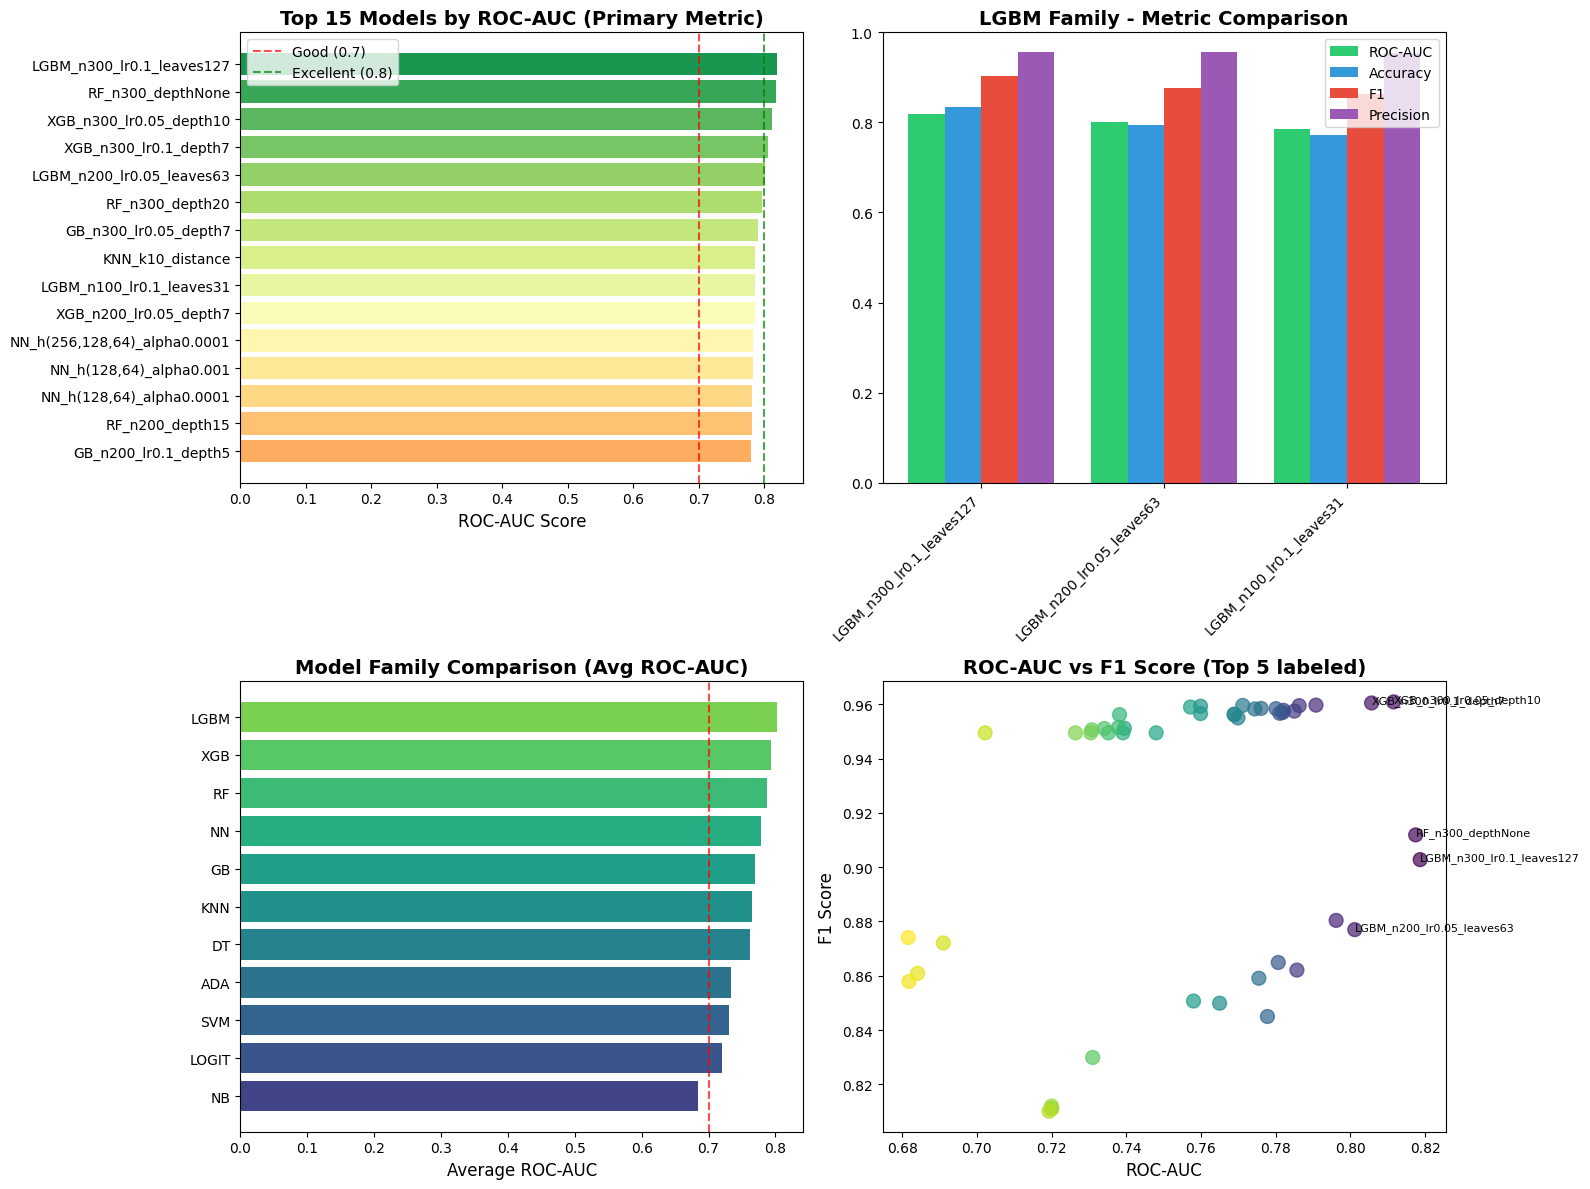


✅ Chart saved as 'model_comparison_optimized.png'


In [13]:
# =================================================================================
# VISUALIZATION
# =================================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 15 by F1 Score
top15 = results_df.head(15).sort_values('f1')
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top15)))
axes[0,0].barh(top15['model'], top15['f1'], color=colors)
axes[0,0].set_xlabel('F1 Score', fontsize=12)
axes[0,0].set_title('Top 15 Models by F1 Score (Primary Metric)', fontsize=14, fontweight='bold')
axes[0,0].axvline(x=0.7, color='red', linestyle='--', alpha=0.7, label='Good (0.7)')
axes[0,0].axvline(x=0.8, color='green', linestyle='--', alpha=0.7, label='Excellent (0.8)')
axes[0,0].legend()

# Plot 2: Metric comparison for best model family
best_family = best['model'].split('_')[0]
family_models = results_df[results_df['model'].str.startswith(best_family)]
x = range(len(family_models))
width = 0.2
axes[0,1].bar([i-width*1.5 for i in x], family_models['f1'], width, label='F1', color='#e74c3c')
axes[0,1].bar([i-width*0.5 for i in x], family_models['accuracy'], width, label='Accuracy', color='#3498db')
axes[0,1].bar([i+width*0.5 for i in x], family_models['roc_auc'], width, label='ROC-AUC', color='#2ecc71')
axes[0,1].bar([i+width*1.5 for i in x], family_models['precision'], width, label='Precision', color='#9b59b6')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(family_models['model'], rotation=45, ha='right')
axes[0,1].set_title(f'{best_family} Family - Metric Comparison', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].set_ylim(0, 1)

# Plot 3: Model family comparison (average F1 Score)
results_df['family'] = results_df['model'].apply(lambda x: x.split('_')[0])
family_avg = results_df.groupby('family')['f1'].mean().sort_values(ascending=True)
colors_family = plt.cm.viridis(np.linspace(0.2, 0.8, len(family_avg)))
axes[1,0].barh(family_avg.index, family_avg.values, color=colors_family)
axes[1,0].set_xlabel('Average F1 Score', fontsize=12)
axes[1,0].set_title('Model Families - Average F1 Score', fontsize=14, fontweight='bold')

# Plot 4: Precision vs Recall tradeoff (color = F1)
scatter = axes[1,1].scatter(results_df['precision'], results_df['recall'], 
                            c=results_df['f1'], cmap='RdYlGn', s=100, alpha=0.7)
axes[1,1].set_xlabel('Precision', fontsize=12)
axes[1,1].set_ylabel('Recall', fontsize=12)
axes[1,1].set_title('Precision vs Recall (color = F1 Score)', fontsize=14, fontweight='bold')
cb = plt.colorbar(scatter, ax=axes[1,1])
cb.set_label('F1 Score')

plt.tight_layout()
plt.savefig('model_comparison_optimized.png', dpi=150, bbox_inches='tight')
plt.show()


In [14]:
# =================================================================================
# BEST MODEL DETAILED ANALYSIS
# =================================================================================

best_model_name = results_df.iloc[0]['model']
print(f"\n{'='*70}")
print(f"DETAILED ANALYSIS: {best_model_name}")
print(f"(Selected by F1 Score)")
print(f"{'='*70}")

# Load best model
best_clf = joblib.load(f"model_{best_model_name}.pkl")

# Predictions
y_pred_best = best_clf.predict(X_test)
y_proba_best = best_clf.predict_proba(X_test)[:, 1]

# Classification report
print("\n" + "-"*40)
print("Classification Report:")
print("-"*40)
print(classification_report(y_test, y_pred_best, target_names=['Denied', 'Approved']))

# Confusion matrix
print("-"*40)
print("Confusion Matrix:")
print("-"*40)
cm = confusion_matrix(y_test, y_pred_best)
print(f"                  Predicted")
print(f"                  Denied  Approved")
print(f"Actual Denied     {cm[0,0]:6d}  {cm[0,1]:6d}")
print(f"Actual Approved   {cm[1,0]:6d}  {cm[1,1]:6d}")



DETAILED ANALYSIS: LGBM_n300_lr0.1_leaves127

----------------------------------------
Classification Report:
----------------------------------------
              precision    recall  f1-score   support

      Denied       0.32      0.64      0.42      6026
    Approved       0.96      0.85      0.90     56617

    accuracy                           0.83     62643
   macro avg       0.64      0.74      0.66     62643
weighted avg       0.90      0.83      0.86     62643

----------------------------------------
Confusion Matrix:
----------------------------------------
                  Predicted
                  Denied  Approved
Actual Denied       3827    2199
Actual Approved     8223   48394


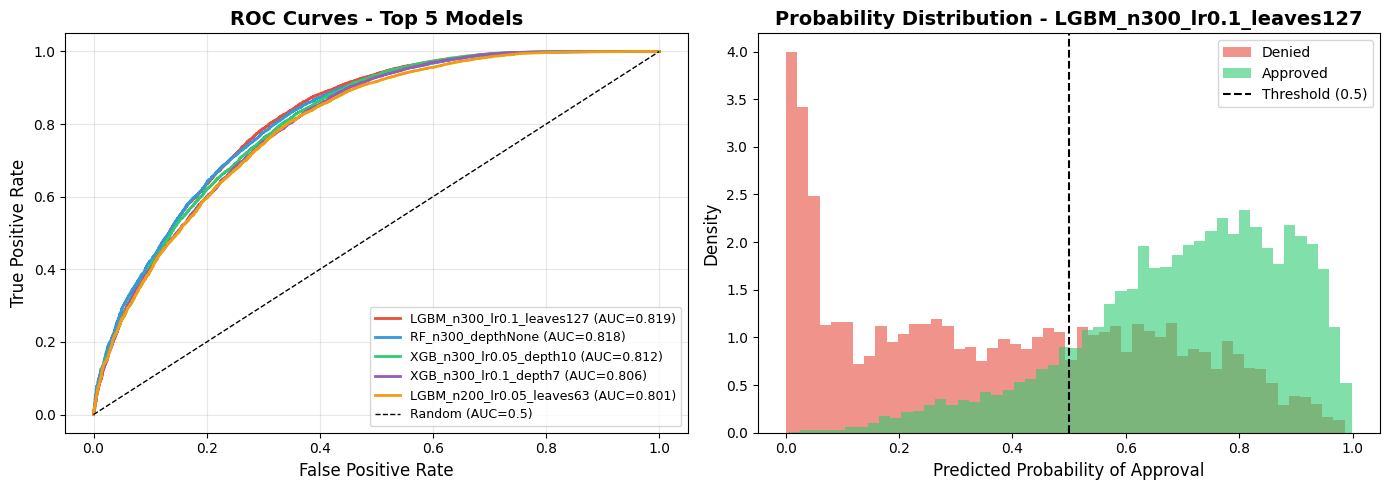

In [15]:
# =================================================================================
# PRECISION-RECALL & ROC CURVES
# =================================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision-Recall curves for top 5 models (more relevant for F1)
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']
for idx, row in results_df.head(5).iterrows():
    model_name = row['model']
    clf = joblib.load(f"model_{model_name}.pkl")
    y_proba = clf.predict_proba(X_test)[:, 1]
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    axes[0].plot(recall_curve, precision_curve, color=colors[idx], lw=2,
                 label=f"{model_name} (F1={row['f1']:.3f})")

axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall Curves - Top 5 Models', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower left', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Probability distribution for best model
axes[1].hist(y_proba_best[y_test==0], bins=50, alpha=0.6, label='Denied', color='#e74c3c', density=True)
axes[1].hist(y_proba_best[y_test==1], bins=50, alpha=0.6, label='Approved', color='#2ecc71', density=True)
axes[1].axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability of Approval', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title(f'Probability Distribution - {best_model_name}', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()


In [16]:
# =================================================================================
# PRACTICAL APPLICATION: Case Prioritization for Law Firm
# =================================================================================

print("\n" + "="*70)
print("PRACTICAL APPLICATION: Law Firm Case Prioritization")
print("="*70)

# Create risk tiers based on predicted probability
def assign_priority(prob):
    if prob < 0.4:
        return "HIGH PRIORITY - Extra Attention Needed"
    elif prob < 0.6:
        return "MEDIUM PRIORITY - Standard Processing"
    elif prob < 0.8:
        return "LOW PRIORITY - Likely to be Approved"
    else:
        return "STREAMLINE - Very High Approval Likelihood"

# Apply to test set
test_results = X_test.copy()
test_results['Actual_Outcome'] = y_test.values
test_results['Predicted_Probability'] = y_proba_best
test_results['Priority_Tier'] = test_results['Predicted_Probability'].apply(assign_priority)

print("\n📊 Case Distribution by Priority Tier:")
print("-"*50)
tier_dist = test_results.groupby('Priority_Tier').agg({
    'Actual_Outcome': ['count', 'mean']
}).round(3)
tier_dist.columns = ['Case Count', 'Actual Approval Rate']
tier_dist = tier_dist.sort_values('Actual Approval Rate')
print(tier_dist)

print("\n" + "-"*50)
print("HOW TO USE THIS FOR THE LAW FIRM:")
print("-"*50)
print("""
1. HIGH PRIORITY (< 40% probability):
   → Assign senior attorneys
   → Extra documentation review
   → Consider strengthening the case before filing

2. MEDIUM PRIORITY (40-60% probability):
   → Standard processing
   → Regular documentation checks

3. LOW PRIORITY (60-80% probability):
   → Can be processed efficiently
   → Standard workflow

4. STREAMLINE (> 80% probability):
   → Fast-track processing
   → Junior staff can handle
   → Minimal review needed
""")


PRACTICAL APPLICATION: Law Firm Case Prioritization

📊 Case Distribution by Priority Tier:
--------------------------------------------------
                                            Case Count  Actual Approval Rate
Priority_Tier                                                               
HIGH PRIORITY - Extra Attention Needed            7695                 0.581
MEDIUM PRIORITY - Standard Processing            11590                 0.895
LOW PRIORITY - Likely to be Approved             22898                 0.951
STREAMLINE - Very High Approval Likelihood       20460                 0.978

--------------------------------------------------
HOW TO USE THIS FOR THE LAW FIRM:
--------------------------------------------------

1. HIGH PRIORITY (< 40% probability):
   → Assign senior attorneys
   → Extra documentation review
   → Consider strengthening the case before filing

2. MEDIUM PRIORITY (40-60% probability):
   → Standard processing
   → Regular documentation checks

3. LO

In [17]:
# =================================================================================
# SAVE RESULTS AND DOWNLOAD
# =================================================================================

# Save all results
results_df.to_csv('model_results_optimized.csv', index=False)
print("✅ Model results saved to 'model_results_optimized.csv'")

# Save best model for deployment
joblib.dump(best_clf, 'best_model_for_deployment.pkl')
print(f"✅ Best model ({best_model_name}) saved for deployment")

# Summary report
summary = f"""
PERM EB2 Approval Prediction - Model Summary
=============================================
PRIMARY METRIC: F1 SCORE

Dataset:
- Years: 2022, 2023, 2024 (combined)
- Total samples: {len(perm_model):,}
- Training samples: {len(X_train):,}
- Test samples: {len(X_test):,}
- Approval rate: {y.mean():.1%}

Target Definition:
- Approved (1): Certified + Certified-Expired
- Denied (0): Denied + Withdrawn

Best Model: {best_model_name}
- F1 Score:  {best['f1']:.4f} ← Primary metric for approval prediction
- ROC-AUC:   {best['roc_auc']:.4f}
- Accuracy:  {best['accuracy']:.4f}
- Precision: {best['precision']:.4f}
- Recall:    {best['recall']:.4f}

Models Trained: {len(results_df)}

Use Case: Law firm case prioritization
- Use predicted probabilities to prioritize cases
- Low probability cases get more attention
- High probability cases can be streamlined
- F1 Score tells you how reliable the predictions are
"""

with open('summary_report.txt', 'w') as f:
    f.write(summary)
print("✅ Summary report saved")

print(summary)

# Download files
from google.colab import files
files.download('model_results_optimized.csv')
files.download('model_comparison_optimized.png')
files.download('roc_curves.png')
files.download('summary_report.txt')


✅ Model results saved to 'model_results_optimized.csv'
✅ Best model (LGBM_n300_lr0.1_leaves127) saved for deployment
✅ Summary report saved

PERM EB2 Approval Prediction - Model Summary

Dataset:
- Years: 2022, 2023, 2024 (combined)
- Total samples: 313,213
- Training samples: 250,570
- Test samples: 62,643
- Approval rate: 90.4%

Target Definition:
- Approved (1): Certified + Certified-Expired
- Denied (0): Denied + Withdrawn

Best Model: LGBM_n300_lr0.1_leaves127
- ROC-AUC: 0.8187 (Primary metric for case ranking)
- Accuracy: 0.8336
- F1 Score: 0.9028
- Precision: 0.9565
- Recall: 0.8548

Models Trained: 48

Use Case: Law firm case prioritization
- Higher probability → Streamline workflow
- Lower probability → Prioritize attention



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary

### Key Changes from Previous Version:

1. **Combined all years** (2022, 2023, 2024) - more training data

2. **Fixed target definition**:
   - Certified + Certified-Expired = APPROVED
   - This correctly captures USCIS approval decisions

3. **Added powerful models**:
   - XGBoost (often best for tabular data)
   - LightGBM (fast and accurate)
   - AdaBoost

4. **Better features**:
   - Log-transformed wages (handles skewness)
   - Regional grouping (reduces cardinality)
   - More numeric features

5. **Optimized for F1 Score** (per professor's feedback):
   - Best metric for approval probability prediction
   - Balances precision and recall
   - Shows how well model classifies approved vs denied

### For the Law Firm:
- Use predicted probabilities to prioritize cases
- Low probability cases get more attention
- High probability cases can be streamlined
- F1 Score tells you how reliable the classification is
